In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tf
import torchvision.datasets as tfds
import torchvision
from torchvision.transforms import ToPILImage

In [96]:
imgfolder = ImageFolder('./COVID-19_Radiography_Database/images/',
                       transform=tf.Compose([
                                             tf.Resize((224,224)),
                                             tf.ToTensor()
                                            ]))

In [97]:
from torch.utils.data import Subset

In [98]:
from sklearn.model_selection import train_test_split

In [197]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [198]:
print(len(imgfolder))
datasets = train_val_dataset(imgfolder)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

2905
2324
581
Dataset ImageFolder
    Number of datapoints: 2905
    Root location: ./COVID-19_Radiography_Database/images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [47]:
len(x)

2905

In [38]:
d = {}
for i in x:
    if i in d.keys():
        d[i] += 1
    else:
        d[i] = 1

In [39]:
d

{0: 219, 1: 1341, 2: 1345}

In [48]:
x = list(imgfolder.class_to_idx.keys())

In [49]:
x

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [13]:
{i:j for i,j in zip(x, d.values())}

{'COVID-19': 219, 'NORMAL': 1341, 'Viral Pneumonia': 1345}

In [199]:
dataset_loader = torch.utils.data.DataLoader(datasets['train'],
                                             batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(datasets['val'],
                                             batch_size=32, shuffle=False)

In [104]:
x = next(iter(dataset_loader))

In [114]:
inpt = x[0]

In [244]:
inpt.shape

torch.Size([16, 3, 224, 224])

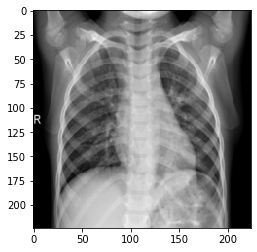

In [123]:
plt.imshow(inpt[1].permute(1,2,0))

In [184]:
def show(img):
    plt.imshow(img.permute(1,2,0))

In [185]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [186]:
label

tensor([2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2])

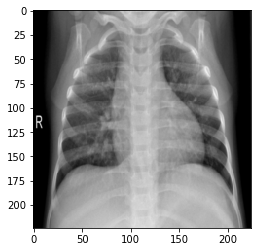

In [187]:
show(inpt[4])

In [147]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1,) #512
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) #256
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) #128
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) #64
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()

        
        self.fc1 = nn.Linear(14*14*128, 120)  # 6*6 from image dimension
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(84, 28)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(28, 10)
        torch.nn.init.kaiming_normal_(self.fc4.weight)
        self.fc5 = nn.Linear(10,3)
        torch.nn.init.kaiming_normal_(self.fc5.weight)

    def forward(self, x):
        x = F.relu(F.avg_pool2d(self.bn1(self.conv1(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn2(self.conv2(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn3(self.conv3(x)),3,1,1))
        x = F.relu(F.avg_pool2d(self.bn4(self.conv4(x)),3,1,1))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = F.softmax(x)
        return x



net = Net()

In [148]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print statistics
        running_loss += loss.item()
        if i % 19 == 0:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
            with torch.no_grad():
                i = 0
                val_loss = 0.0
                for i, data in enumerate(val_loader):
                    i+=1
                    inpt, label = data
                    output = net(inpt)
                    loss = criterion(output, label)
                    val_loss+=loss

                print(f'validation loss {val_loss/i:.3f}')
                
            

print('Finished Training')

In [ ]:
net.

In [140]:
output

tensor([[6.6530e-04, 9.9910e-01, 2.3693e-04],
        [1.7690e-05, 1.7309e-01, 8.2689e-01],
        [2.7723e-04, 9.9963e-01, 9.0987e-05],
        [1.2721e-07, 1.1359e-05, 9.9999e-01],
        [1.1363e-04, 1.4596e-03, 9.9843e-01],
        [2.6355e-04, 6.6842e-01, 3.3132e-01],
        [1.4635e-09, 6.3059e-06, 9.9999e-01],
        [7.8410e-05, 9.9990e-01, 2.5382e-05],
        [8.0004e-05, 9.9987e-01, 4.9701e-05],
        [9.5724e-05, 9.9986e-01, 3.9690e-05],
        [7.0814e-05, 9.9989e-01, 3.6282e-05],
        [9.9993e-01, 6.1610e-05, 7.4833e-06],
        [1.0578e-04, 9.9988e-01, 1.0756e-05],
        [9.9333e-01, 6.1468e-03, 5.2161e-04],
        [3.0236e-04, 1.5156e-01, 8.4814e-01],
        [4.9297e-08, 9.4834e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward>)

In [200]:
inpt, label = next(iter(val_loader))

In [201]:
output = net(inpt)

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [205]:
x = []
total = 0
for i in output:
    x.append(list(i).index(max(i)))
for i,j in zip(x,label):
    if i == j:
        total +=1
        
x, label, total/32

([2,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  1,
  1,
  2,
  2,
  1,
  2,
  2,
  1,
  1,
  2,
  1,
  1,
  1,
  2,
  1,
  2],
 tensor([2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 1]),
 0.84375)

In [203]:
loss = criterion(output, label)

In [204]:
loss

tensor(0.6968, grad_fn=<NllLossBackward>)